In [44]:
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

useDeng = False

if useDeng: images = glob.glob('deng/*.bmp')
else: images = glob.glob('camera2/*.jpg')
patternSize = (11,12)
squareSize = 30
imgSize = (640,480)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [45]:
def construct3DPoints(patternSize,squareSize):
    X = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
    X[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
    X = X * squareSize
    return X

boardPoints = construct3DPoints(patternSize,squareSize)
worldPoints = []
imagePoints = [] 

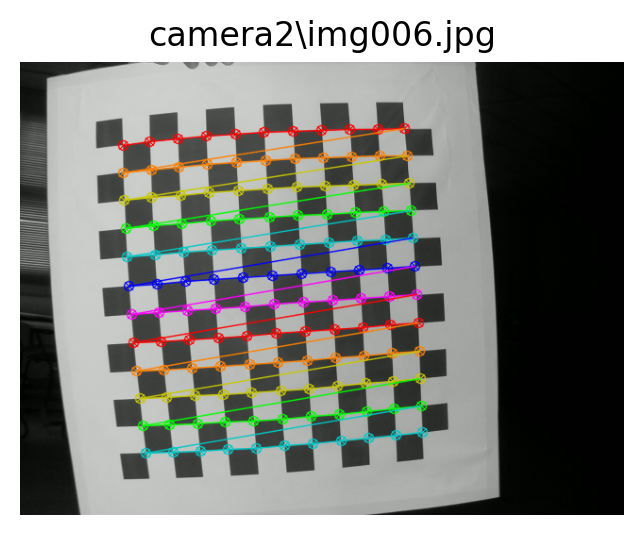

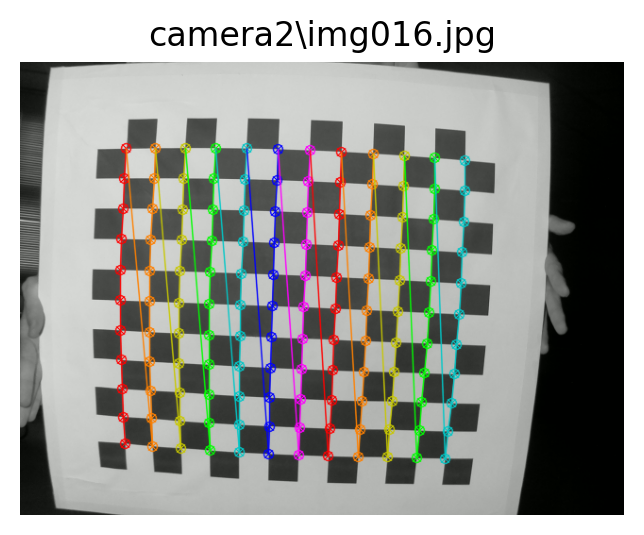

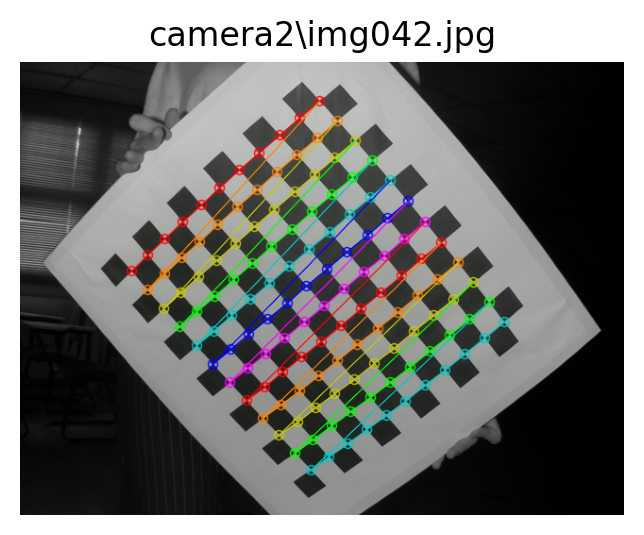

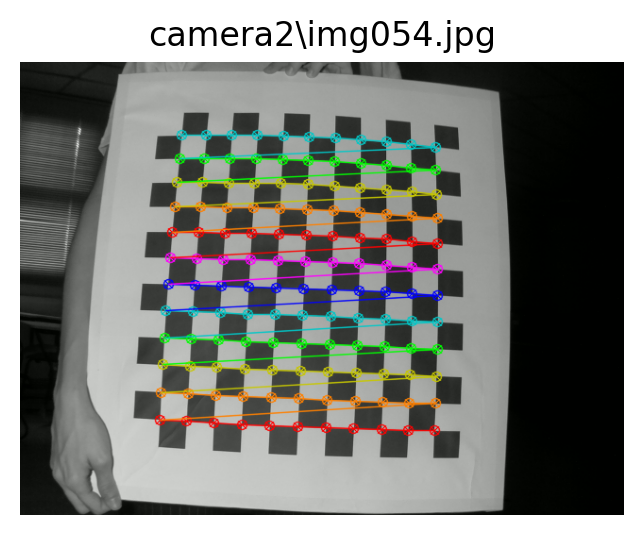

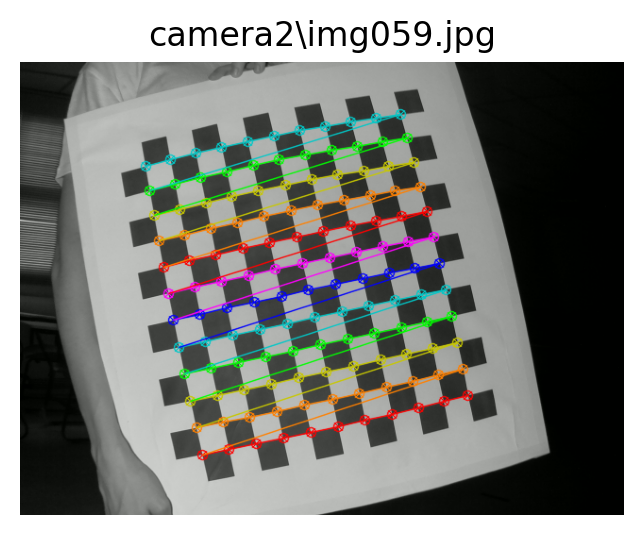

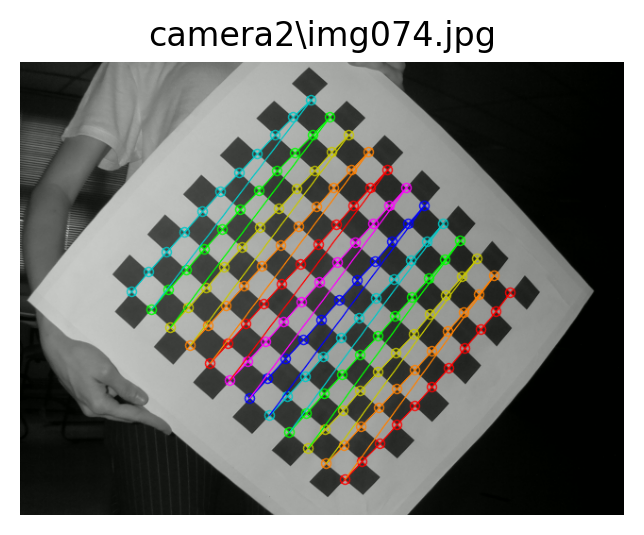

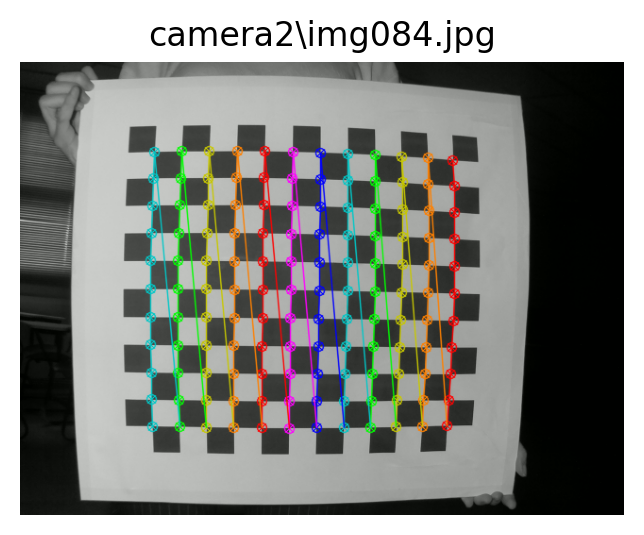

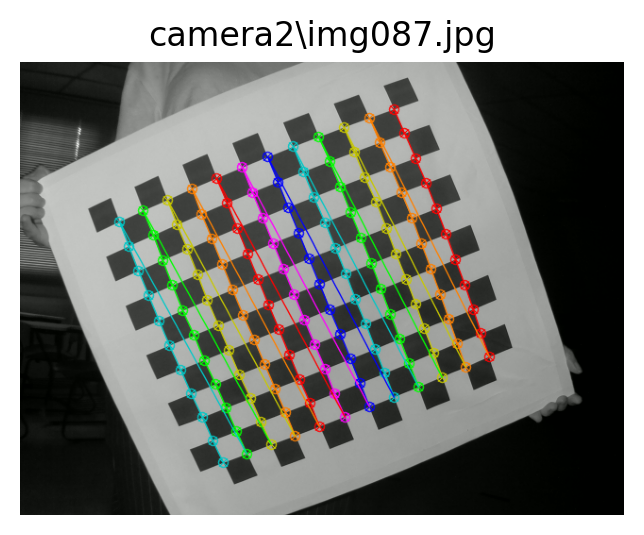

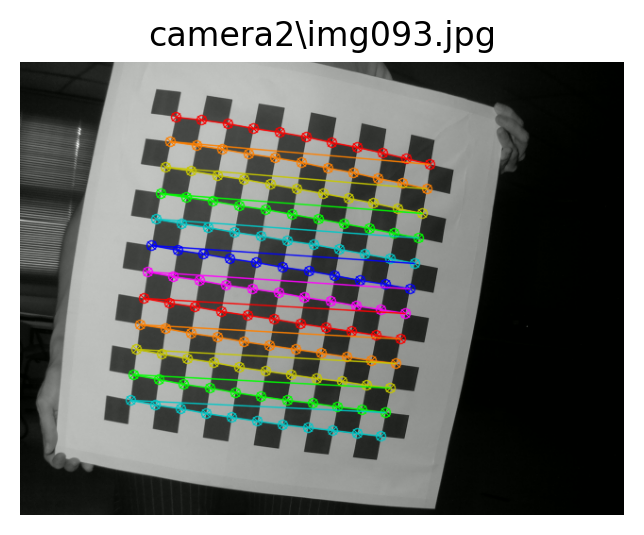

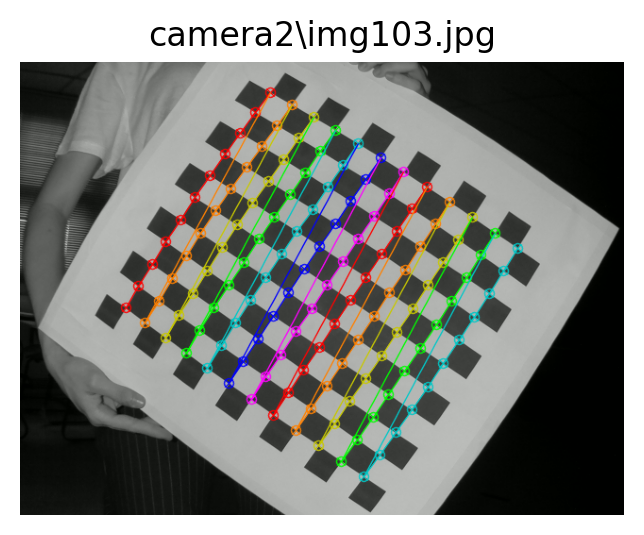

In [46]:
counter = 0
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, patternSize, None)
    if ret == True:
        cornersRefined = cv2.cornerSubPix(gray, corners, (7,7), (-1,-1), criteria)
        imagePoints.append(cornersRefined)
        worldPoints.append(boardPoints)
        counter+=1
        cv2.drawChessboardCorners(img, patternSize, cornersRefined, ret)
        plt.figure(figsize=(4, 3), dpi=200)
        plt.imshow(img[:,:,::-1])
        plt.axis('off')
        plt.title(fname)
        cv2.imwrite(str(counter)+'Markers.png', img)

In [47]:
flagsCalib = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW+cv2.fisheye.CALIB_CHECK_COND
calibrateCriteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,30, 1e-12)
ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(np.expand_dims(np.asarray(worldPoints), -2), imagePoints, imgSize, None, None,
                                                            flags=flagsCalib,criteria=calibrateCriteria)
print("Using "+str(counter)+" of "+str(len(images))+" images")
print("RMS re-projection error:", ret)
print("Camera Matrix:\n", cameraMatrix)
print("Distortion Parameters:\n", k)

Using 10 of 10 images
RMS re-projection error: 0.4156438029380603
Camera Matrix:
 [[674.0601043    0.         294.44428747]
 [  0.         673.05176568 273.40223251]
 [  0.           0.           1.        ]]
Distortion Parameters:
 [[-0.10086723]
 [ 0.06522408]
 [-2.83195576]
 [15.35692146]]


In [65]:
def undistort(imgpath,K,D,DIM,axis,method,scale,corners):
    img = cv2.imread(imgpath)
    DIM = img.shape[:2][::-1] 

    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, DIM, np.eye(3), balance=1)

    '''new_K = K.copy()
    new_K[0,0]=K[0,0]*scale
    new_K[1,1]=K[1,1]*scale'''
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), new_K, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    fx = new_K[0,0]
    fy = new_K[1,1]
    cx = new_K[0,2]
    cy = new_K[1,2]
    undCorners_norm = cv2.fisheye.undistortPoints(corners, K, D)
    undCorners_norm = undCorners_norm.reshape(-1,2)
    undistCorners = np.zeros_like(undCorners_norm)
    for i, (x, y) in enumerate(undCorners_norm):
        px = x*fx + cx
        py = y*fy + cy
        undistCorners[i,0] = px
        undistCorners[i,1] = py    
    cv2.drawChessboardCorners(undistorted_img, patternSize, undistCorners, _)

    axs[axis].imshow(undistorted_img[:,:,::-1])
    axs[axis].axis('off')
    axs[axis].set_title('undistort')
    cv2.imwrite('undistort'+method+'.png', undistorted_img)

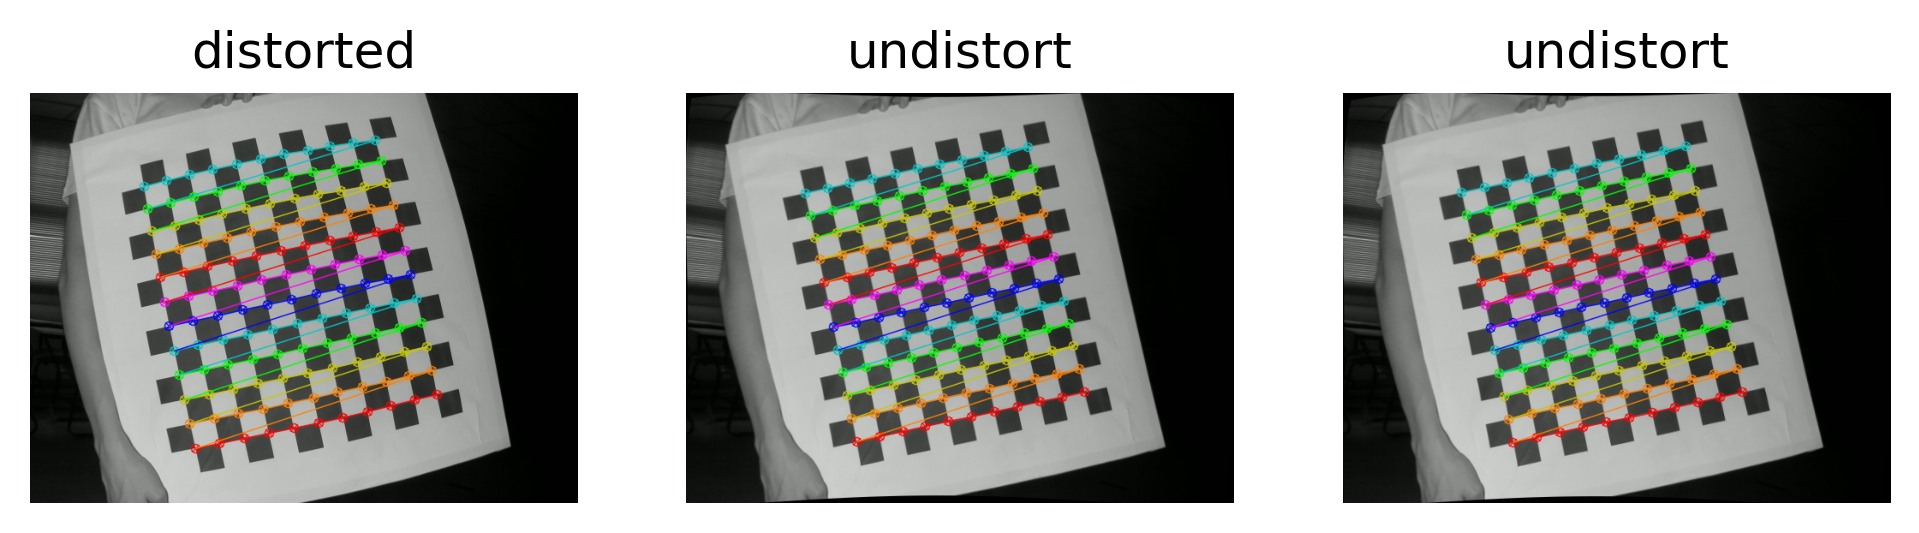

In [66]:
pathImg = images[4]
img = cv2.imread(pathImg)

fig, axs = plt.subplots(1,3,figsize=(8, 2), dpi=300)
_, corners = cv2.findChessboardCorners(img, patternSize, None)
cv2.drawChessboardCorners(img, patternSize, corners, _)
axs[0].imshow(img[:,:,::-1])
axs[0].axis('off')
axs[0].set_title('distorted')
cv2.imwrite('undistortNOriginal.png', img)

undistort(pathImg,cameraMatrix,k,imgSize,1,'openCV',1,corners)

if useDeng:
    k[0] = 0.2377
    k[1] = -0.3752
    k[2] = 6.6712
    k[3] = -27.4156
else:
    '''k[0] = -0.1012
    k[1] = -0.3790
    k[2] = 3.7397
    k[3] = -8.8659
    cameraMatrix[0][0] = 675.1068
    cameraMatrix[1][1] = 674.7367
    cameraMatrix[0][2] = 306.3802
    cameraMatrix[1][2] = 246.0408 '''
    k[0] = -0.1158
    k[1] = 0.3868
    k[2] = -5.3301
    k[3] = 22.1841
    cameraMatrix[0][0] = 675.0792
    cameraMatrix[1][1] = 674.0334
    cameraMatrix[0][2] = 295.3214
    cameraMatrix[1][2] = 274.4029

undistort(pathImg,cameraMatrix,k,imgSize,2,'MATLAB',1,corners)